In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

## Create the model

Notebook to test stuff in PyTorch. 

In [2]:
class MLP(nn.Module):
    def __init__(self, name, input_size, output_size) -> None:
        super(MLP, self).__init__()
        self.name = name
        self.input_size = input_size
        self.output_size = output_size
        self.fc1 = nn.Linear(input_size, 115)  # linear: y = Ax + b
        self.fc2 = nn.Linear(115, 78)
        self.fc3 = nn.Linear(78, 26)
        self.fc4 = nn.Linear(26, 46)
        self.fc5 = nn.Linear(46, 82)
        self.fc6 = nn.Linear(82, 106)
        self.fc7 = nn.Linear(106, output_size)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.relu(x)
        x = self.fc5(x)
        x = F.relu(x)
        x = self.fc6(x)
        x = F.relu(x)
        x = self.fc7(x)
        
        output = x = F.relu(x)
        return output


Generate fake data (to be replaced with the actual get data functions)

In [3]:
features = np.random.rand(128, 4)  # 4 dimensional features
labels = np.random.rand(128, 5)  # 5 dimensional labels

In [4]:
features = torch.FloatTensor(features)
labels = torch.FloatTensor(labels)

In [5]:
model = MLP('M502', 4, 5)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Preparing your data for training with DataLoaders

The `Dataset` retrieves our dataset’s features and labels one sample at a time. While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s `multiprocessing` to speed up data retrieval.

`DataLoader` is an iterable that abstracts this complexity for us in an easy API.

```
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)
```

In [10]:
dataset = TensorDataset(features, labels)
trainloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [17]:
from tqdm import trange
model.train()
epochs = 20
batch_size = 32

epoch_loss = []

for epoch in trange(epochs):

    loop = tqdm(trainloader)
    running_loss = 0.0

    for i, batch_data in enumerate(loop):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch_data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        loop.set_postfix(loss=running_loss, epoch_loss=loss.item())
        loop.set_description(f'Epoch {epoch}/{epochs}')
        loop.set_postfix(loss=running_loss)
                
        running_loss = 0.0
    epoch_loss.append(loss.item())


print('Finished training')
print(epoch_loss)

100%|██████████| 20/20 [00:01<00:00, 17.57it/s]


Finished training
[0.14540860056877136, 0.1318661868572235, 0.1057579517364502, 0.14405135810375214, 0.14463591575622559, 0.1278773993253708, 0.13984230160713196, 0.14570480585098267, 0.11914557218551636, 0.13593044877052307, 0.139154314994812, 0.14343319833278656, 0.12108955532312393, 0.12703101336956024, 0.11688075214624405, 0.1244545578956604, 0.12813842296600342, 0.1361343115568161, 0.14333157241344452, 0.13820573687553406]


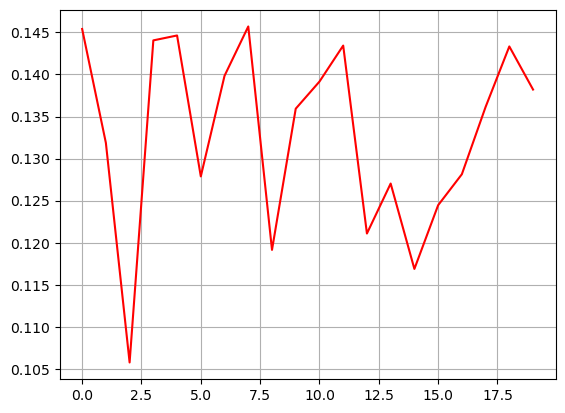

In [19]:
fig, ax = plt.subplots()
ax.plot(epoch_loss, c='r')
ax.grid()

## Test coefficient scaling function

In [3]:
def c_e(epoch, c=0.5, r=25, which='exp'):
    """Get regularization coefficient.

    c is generated following an exponential function

    Args:
        epoch (int): Current epoch.
        c (float, optional): Regularization coefficient to be approached. Defaults to 0.5.
        r (int, optional): Rate of increase. Coefficient increases by {} over r epochs. Defaults to 25.

    Returns:
        c: Coefficient at each epoch.
    """

    if which=='exp':
        return c - c*np.exp(-epoch/r)
    elif which=='sigmoid':
        k = 0.085
        x_0 = 100
        return c/(1 + np.exp(-k*(epoch-x_0)))

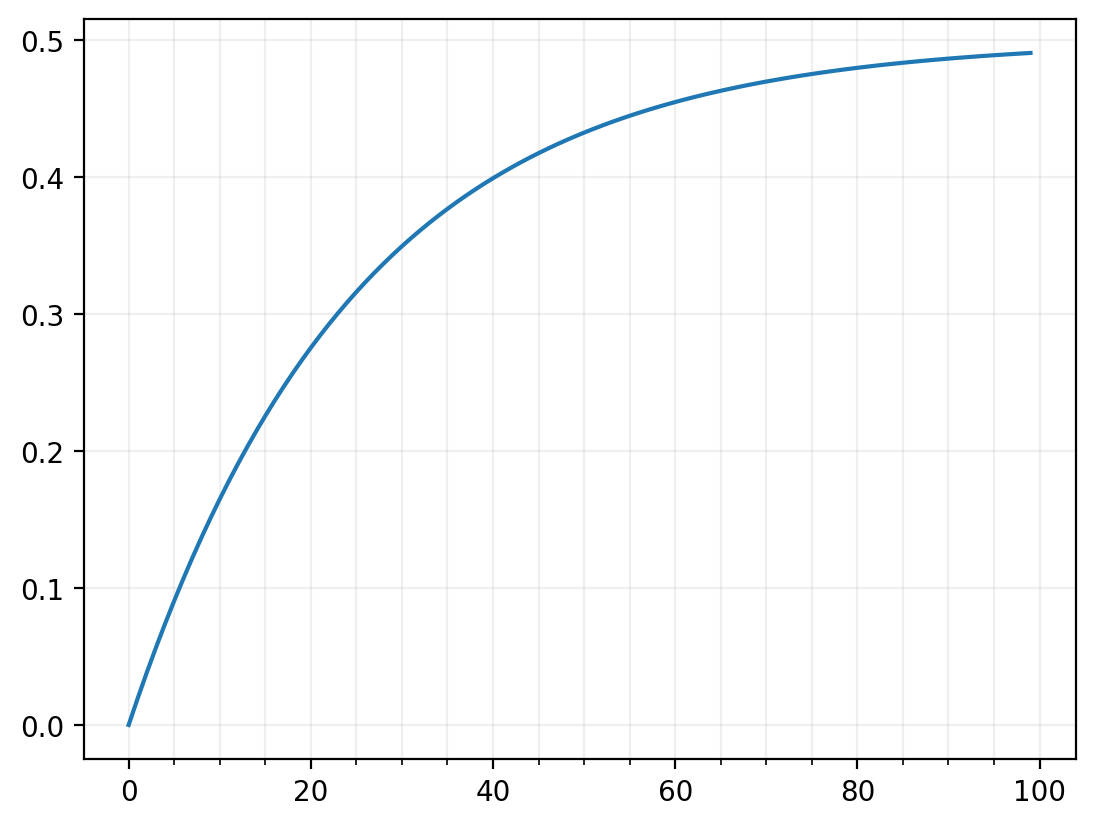

In [9]:
from matplotlib.ticker import MultipleLocator
x_plot = np.arange(0, 100)

fig, ax = plt.subplots(dpi=200)
ax.plot(x_plot, c_e(x_plot))
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.grid(which = 'both', alpha=0.2)